# Connect Four AI

Wassup! I have no idea what I'm doing, but here goes.

So I _finally_ coded up a working Connect Four game in Python, and now comes the fun part. I'm going to follow the style of the tutorial on Medium and start with a simple Q-table implementation.

In [ ]:
from ConnectFour import Game
import numpy as np

g = Game()
g.play(0) # player 1 move
g.play(0) # player 2 move
g.play(1) # and back to player 1

Above is a sample output of what the computer gets for each move: a "reward" (only nonzero when you win/lose), the state of the board, and an indication of whether the game is over or not.

## Constructing the Neural Network

In [9]:
from ConnectFour import Game
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

g = Game()

# constructing the network
tf.reset_default_graph()
inputs1 = tf.placeholder(shape=[1,84], dtype=tf.float32) # the input is the current state, i.e. the entire board
W = tf.Variable(tf.random_uniform([84,7], 0, 0.1)) # the weights for a single layer network are this
Qout = tf.matmul(inputs1, W) # predicting Q values using network
predict = tf.argmax(Qout, 1) # finding best predicted action from Qout

# constructing the loss function
nextQ = tf.placeholder(shape=[1,7], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
updateModel = trainer.minimize(loss)

# some magic initializer or something, and a saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# hyperparameters
y = 0.99 # discount rate for Bellman equation
e = 0.1 # chance of random action being taken
n_episodes = 1000

jList = [] # number of steps for each game
rList = [] # maximum reward for each game

model_num = 3

with tf.Session() as sess:
    sess.run(init)
    
    # restore if I'm picking up from a previously saved model
    saver.restore(sess, "./saved/model_2")
    
    for i in range(n_episodes):
        if i%100 is 0:
            print('On episode {}'.format(i))
        
        # reset the game
        g.reset()
        rAll = 0
        d = False
        j = 0
        sPrev = None # the previous state at turn's start for the opposing player
        aPrev = None # the previous action by opposing player
        allQPrev = None # the previous set of Q values for opposing player
        maxQ1Prev = None # the maximum predicted Q value after action by opposing player
        while j < 99:
            j += 1
            s = g.getState()
            a, allQ = sess.run([predict, Qout], feed_dict={inputs1:s.reshape((1,84))})
            # pick a random move
            if np.random.rand(1) < e:
                a[0] = np.random.randint(7) 
            # make the move, get the reward
            while True: # ensures it makes a move
                try:
                    s1, r, d = g.play(a[0])
                    break
                except:
                    # first check if game is still playable
                    if g.isPlayable():
                        a[0] = np.random.randint(7)
                    else:
                        s1 = s
                        r = 0
                        d = True
                        break
            # train the model based on the reward the person got
            Q1 = sess.run(Qout, {inputs1:s1.reshape((1,84))})
            maxQ1 = np.max(Q1)
            targetQ = allQ
            # not sure why it's 0, a[0] here... Wait, I think it's because
            # targetQ is 1x7 vector, and only want to update the Q value for
            # the given state/action pair
            targetQ[0, a[0]] = r + y*maxQ1
            # train model based on new value
            _, W1 = sess.run([updateModel, W], {inputs1: s.reshape((1,84)), nextQ: targetQ})
            
            # penalize bad moves by players if the other one wins
            if sPrev is not None and r is 1:
                targetQ = allQPrev
                targetQ[0, aPrev[0]] = -1 + y*maxQ1Prev
                _, W1 = sess.run([updateModel, W], {inputs1: sPrev.reshape((1,84)), nextQ: targetQ})
            
            # keep track of total rewards (will be 1/game if someone wins)
            rAll += r
            
            # keep track of the player's state and moves
            sPrev = s
            aPrev = a
            allQPrev = allQ
            maxQ1Prev = maxQ1
            if d:
                e = 1. / ((i/50.) + 10)
                break
        
        jList.append(j)
        rList.append(rAll)
    
    # save the current model and vars to file
    savePath = saver.save(sess, './saved/model_{}'.format(model_num))
    print('Trained model saved to {}'.format(savePath))

print('Percent successful episodes: {}%'.format(sum(rList)/n_episodes * 100))

INFO:tensorflow:Restoring parameters from ./saved/model_2
On episode 0
On episode 100
On episode 200
On episode 300
On episode 400
On episode 500
On episode 600
On episode 700
On episode 800
On episode 900
Trained model saved to ./saved/model_3
Percent successful episodes: 99.8%


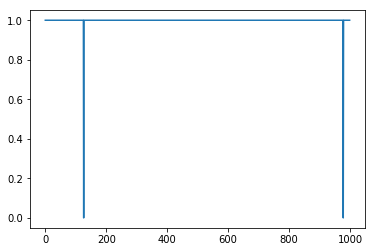

In [10]:
plt.plot(rList)

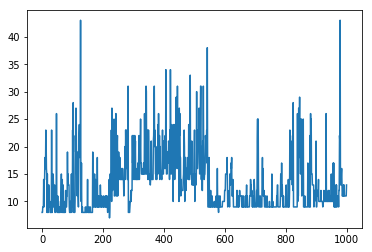

In [11]:
plt.plot(jList)

### So... What did I just do?

I'm not really sure, but the computer did run 2000 episodes of Connect Four and (possibly) trained the Q-network to play. I'm not really sure how to test it, and I've got to run to practice now, but I'll return to this when I get back.

Ok! So I messed around with some stuff above to save/reload models, and now below I'm going to try to implement a me-vs-machine game thingy.

In [14]:
# create a game
g = Game()

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./saved/model_3.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./saved'))
    
    d = False
    while not d:
        print(g)
        # get human input
        while True:
            try:
                play = int(input("Human, enter move: ")) - 1
                _, r, d = g.play(play)
                break
            except:
                if g.isPlayable():
                    print("Error, try again")
                else:
                    d = True
                    break
        if d:
            break
        # then get computer input, first predict best move from Q-network
        print("Computer is thinking...")
        s = g.getState()
        a, allQ = sess.run([predict, Qout], {inputs1: s.reshape((1,84))})
        print("Computer's thought process (Q-values):")
        print(allQ[0] / sum(allQ[0]))
        # then make the move
        print("Computer is making move...")
        while True:
            try:
                _, r, d = g.play(a[0])
                break
            except:
                if g.isPlayable():
                    a[0] = np.random.randint(7)
                else:
                    d = True
                    break
        print("Computer made move in column {}.".format(a[0] + 1))
    print("Winner was {}".format(g.getWinner()))
    print(g.board)

INFO:tensorflow:Restoring parameters from ./saved/model_3
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
---	---	---	---	---	---	---	
1	2	3	4	5	6	7
current player is 1
Human, enter move: 1
Computer is thinking...
Computer's thought process (Q-values):
[ 0.07198504  0.11882721  0.31894577  0.12519966  0.19044846  0.07169049
  0.10290337]
Computer is making move...
Computer made move in column 3.
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
1	-	2	-	-	-	-	
---	---	---	---	---	---	---	
1	2	3	4	5	6	7
current player is 1
Human, enter move: 2
Computer is thinking...
Computer's thought process (Q-values):
[ 0.08588547  0.12813252  0.20020656  0.1470075   0.22380304  0.10044353
  0.11452139]
Computer is making move...
Computer made move in column 5.
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
-	-	-	-	-	-	-	
1	1	2	-	2	-	-	
---	---	---	---	---	---	---	
1	2	3	4	5	6	7
current player is 1
Human, enter move: 2
Co